# 04_stepsize_policy_ablation.ipynb

**Claim under test:**  
Changing stepsize policy alters stability and regret without changing geometry.

**Grid file:** `grids/04_stepsize_ablation.yaml`

**Baseline & conventions**
- Use the STAR schema built by `experiment/utils/duck-db-loader.py`.
- Slice results by `(grid_id, seed)` using `analytics.v_run_summary`.
- Keep plots identical across notebooks; only the *dial* under test changes.
- Reference path-length/regret-decomposition companion analysis for context. :contentReference[oaicite:0]{index=0}

## 0) Imports & paths

In [1]:
from pathlib import Path
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# go up one level
os.chdir("..")
from utils.standardized_analysis import run_all_standardized_analyses, enhance_claim_check_export


# project paths (edit if your repo layout differs)
REPO = Path(".").resolve()
RESULTS_GLOB = "results_parquet/04_stepsize_ablation/events/grid_id=*/seed=*/*.parquet"  # corrected pattern
DB_PATH = REPO/"artifacts"/"star.duckdb"
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

GRID_FILE = REPO/"grids/04_stepsize_ablation.yaml"     # this notebook’s grid
STAGING_TABLE = "staging.events"   # keep default from loader

## 1) Build/load the STAR schema

In [2]:
from utils.duck_db_loader import load_star_schema

con = load_star_schema(
    input_path=str(RESULTS_GLOB),
    db_path=str(DB_PATH),
    staging_table=STAGING_TABLE,
    run_ddl=True,
    create_events_view=True,
)

# sanity: counts
display(con.execute("""
SELECT 'dim_run' t, COUNT(*) c FROM analytics.dim_run
UNION ALL SELECT 'fact_event', COUNT(*) FROM analytics.fact_event
UNION ALL SELECT 'dim_event_type', COUNT(*) FROM analytics.dim_event_type
""").df())

Found 15 files matching pattern: results_parquet/04_stepsize_ablation/events/grid_id=*/seed=*/*.parquet
  f41405118bc64bbe8b44bed9caee1359-0.parquet: 75 columns
  575ca0e415ee489f8170d70192be906e-0.parquet: 75 columns
  2b7751c3aa4c43c0afc1f0686ef55ce2-0.parquet: 75 columns
  f54d8e0c4c0f4a39bde17e861c5c79f0-0.parquet: 75 columns
  cf9ae0638f2746aeb9a838bd0f65b38a-0.parquet: 75 columns
  6570c11ff9964e6a9616b630a562fb0b-0.parquet: 75 columns
  959740e497634f15a98def517bd42650-0.parquet: 75 columns
  5e93e4a662cb45a9954a2c7acc33b438-0.parquet: 75 columns
  32af73df18a54a4e96ebedadc4f112be-0.parquet: 75 columns
  da434de26f0d46a6a30175763608aef0-0.parquet: 75 columns
  28e65f7263f04ff5a7e2add08ad2a17f-0.parquet: 75 columns
  b2b62139decc40e1aa01d295ace93979-0.parquet: 75 columns
  41231a0e33864322a25d2a59294a9f65-0.parquet: 75 columns
  ed7069bfd7214c07b16f4a3b073495f1-0.parquet: 75 columns
  a7d6bb2f8e6942b084e5e95d5ba5e4f8-0.parquet: 75 columns
Total unique columns discovered: 75
All c

,t,c
0,dim_run,5
1,fact_event,149250
2,dim_event_type,4


## 2) Snapshot config & runs

In [3]:
# show the grid dictionary if kept in YAML (optional)
try:
    import yaml, textwrap
    cfg = yaml.safe_load(Path(GRID_FILE).read_text())
    print("grid file:", GRID_FILE)
    print(json.dumps(cfg.get("matrix", {}), indent=2))
except Exception as e:
    print("Note: could not parse YAML grid:", e)

runs = con.execute("""
SELECT *
FROM analytics.v_run_summary
ORDER BY grid_id, seed
""").df()
runs.head()

grid file: /workspaces/unlearning-research-meta/experiment/grids/04_stepsize_ablation.yaml
{
  "gamma_delete": [
    1.75
  ],
  "gamma": [
    1.0
  ],
  "lambda_reg": [
    0.05
  ],
  "lambda_": [
    0.1
  ],
  "rho_total": [
    1.5
  ],
  "delta_b": [
    0.1
  ],
  "target_G": [
    2.0
  ],
  "target_D": [
    2.0
  ],
  "target_c": [
    0.05
  ],
  "target_C": [
    20.0
  ],
  "target_lambda": [
    0.05
  ],
  "target_PT": [
    30.0
  ],
  "target_ST": [
    200000.0
  ],
  "stepsize_policy": [
    "theory",
    "fixed",
    "capped"
  ],
  "eta_max": [
    1.0
  ],
  "D_bound": [
    2.0
  ],
  "path_style": [
    "rotating"
  ],
  "dim": [
    20
  ],
  "T": [
    50000
  ],
  "accountant": [
    "zcdp"
  ],
  "seed": [
    42
  ]
}


,grid_id,seed,run_id,total_events,insert_events,delete_events,avg_regret,min_regret,max_regret,avg_acc,...,max_rho_step,avg_rho_spent,min_rho_spent,max_rho_spent,avg_sigma_step,min_sigma_step,max_sigma_step,avg_sigma_delete,min_sigma_delete,max_sigma_delete
0,bcd3d47e9387,0,bcd3d47e9387_0,29850,23640.0,2361.0,0.542842,-2.910237,21.994087,1.064414,...,1.5,0.0,0.0,0.0,236.050489,236.050489,236.050489,236.050489,236.050489,236.050489
1,bcd3d47e9387,1,bcd3d47e9387_1,29850,20640.0,2064.0,2.254437,-1.676746,44.324046,1.837922,...,1.5,0.0,0.0,0.0,333.393215,333.393215,333.393215,333.393215,333.393215,333.393215
2,bcd3d47e9387,2,bcd3d47e9387_2,29850,24135.0,2412.0,0.688303,-2.934598,27.836506,1.154697,...,1.5,0.0,0.0,0.0,228.645444,228.645444,228.645444,228.645444,228.645444,228.645444
3,bcd3d47e9387,3,bcd3d47e9387_3,29850,0.0,0.0,4.784141,-5.947825,68.423646,2.797808,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,bcd3d47e9387,4,bcd3d47e9387_4,29850,0.0,0.0,8.660271,-3.818162,226.748814,3.655481,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## 3) Standard query helpers

In [4]:
def last_event_frame(con, grid_id:str, seed:int):
    return con.execute("""
    WITH last AS (
      SELECT MAX(event_id) AS last_id
      FROM analytics.fact_event fe
      WHERE fe.grid_id = ? AND fe.seed = ?
    )
    SELECT fe.*
    FROM analytics.fact_event fe
    CROSS JOIN last l
    WHERE fe.event_id = l.last_id AND fe.grid_id = ? AND fe.seed = ?
    """, [grid_id, seed, grid_id, seed]).df()

def trace_frame(con, grid_id:str, seed:int, cols:tuple[str,...]):
    col_list = ", ".join(cols)
    return con.execute(f"""
    SELECT event_id, {col_list}
    FROM analytics.fact_event fe
    WHERE fe.grid_id = ? AND fe.seed = ?
    ORDER BY event_id
    """, [grid_id, seed]).df()

## 4) Plots (standardized)
Keep styling consistent across notebooks for visual comparability.

In [5]:
def plot_traces(df, ycols, title):
    for y in ycols:
        plt.figure()
        plt.plot(df["event_id"], df[y], label=y)
        plt.xlabel("event_id"); plt.ylabel(y); plt.title(f"{title}: {y}")
        plt.legend(); plt.show()

## 5) Notebook-specific check: claim, dial, metrics

Claim under test: Changing stepsize policy alters stability and regret without changing geometry.
Example run: bcd3d47e9387 0


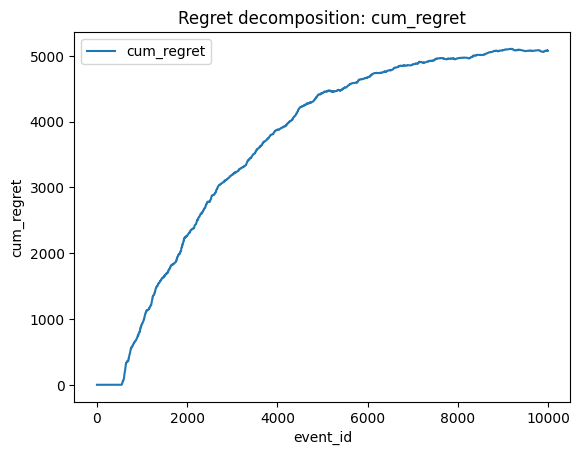

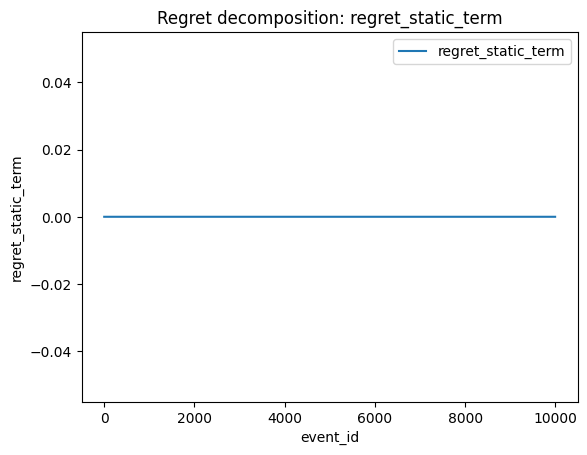

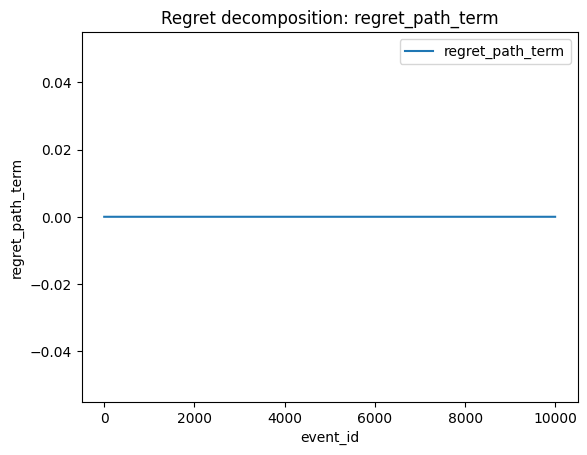

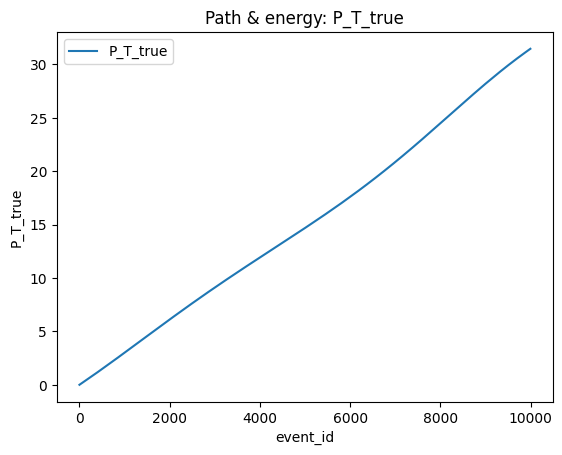

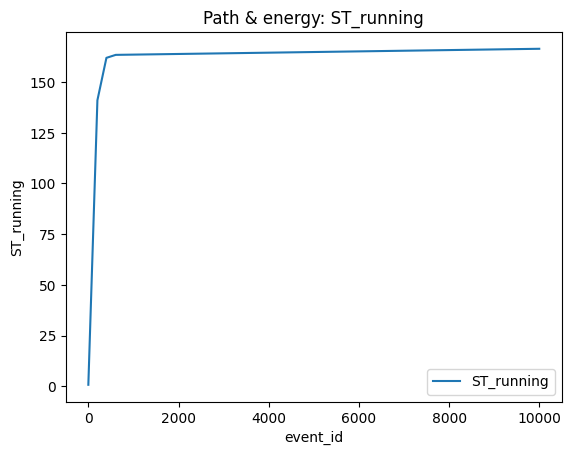

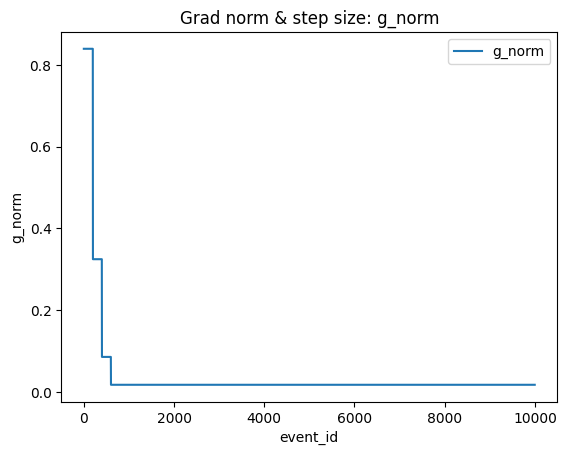

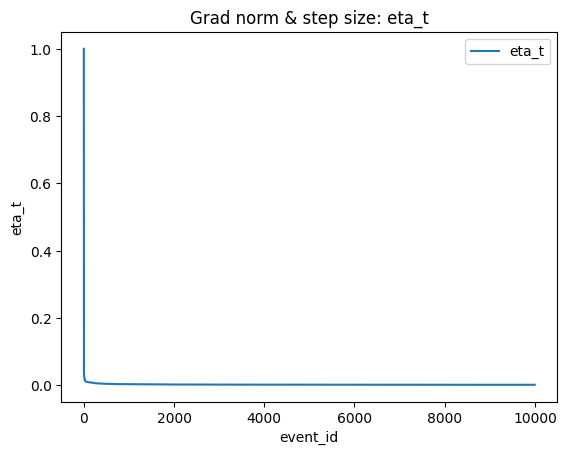

,cum_regret,cum_regret_with_noise,P_T_true,ST_running,rho_spent,m_used
0,5076.994103,5076.994103,31.466027,166.448231,0.0,0
1,5076.994103,5076.994103,31.466027,166.448231,0.0,0
2,5076.994103,5076.994103,31.466027,166.448231,0.0,0


In [6]:
NOTEBOOK_CLAIM = "Changing stepsize policy alters stability and regret without changing geometry."
print("Claim under test:", NOTEBOOK_CLAIM)

# choose a (grid_id, seed) to visualize (edit if multiple)
if not runs.empty:
    gid, seed = runs.loc[0, ["grid_id","seed"]]
    print("Example run:", gid, seed)

    # universal traces
    df = trace_frame(con, gid, int(seed), (
        "cum_regret", "regret_static_term", "regret_path_term",
        "P_T_true", "ST_running", "g_norm", "eta_t"
    ))
    plot_traces(df, ["cum_regret","regret_static_term","regret_path_term"], "Regret decomposition")
    plot_traces(df, ["P_T_true","ST_running"], "Path & energy")
    plot_traces(df, ["g_norm","eta_t"], "Grad norm & step size")

    # end-of-run snapshot
    tail = last_event_frame(con, gid, int(seed))
    display(tail[["cum_regret","cum_regret_with_noise","P_T_true","ST_running","rho_spent","m_used"]])

## 5.5) Standardized Analysis Follow-ups
Execute common analyses across all experiment notebooks for automated claim checks and theory validation.

In [7]:
import numpy as np
# Import standardized analysis functions
import sys


# Run all standardized analyses
analysis_results = run_all_standardized_analyses(con, runs)

# Display summary statistics
print("\n=== THEORY BOUND TRACKING ===")
theory_results = analysis_results['theory_bound_tracking']
successful_theory = [r for r in theory_results.values() if r['status'] == 'success']
if successful_theory:
    ratios = [r['theory_ratio_final'] for r in successful_theory if r['theory_ratio_final'] is not None]
    if ratios:
        print(f"Theory ratio - Mean: {np.mean(ratios):.3f}, Median: {np.median(ratios):.3f}")
        print(f"Expected: O(1) when theory matches experiment")
        
print("\n=== STEPSIZE POLICY VALIDATION ===")
stepsize_results = analysis_results['stepsize_policy_validation']
policy_pass = sum(1 for r in stepsize_results.values() if r['stepsize_policy_status'] == 'pass')
policy_total = len([r for r in stepsize_results.values() if r['stepsize_policy_status'] in ['pass', 'fail']])
if policy_total > 0:
    print(f"Stepsize policy adherence: {policy_pass}/{policy_total} runs passed")
    
print("\n=== PRIVACY & ODOMETER SANITY CHECKS ===")
privacy_results = analysis_results['privacy_odometer_checks']
privacy_pass = sum(1 for r in privacy_results.values() if r['privacy_odometer_status'] == 'pass')
privacy_total = len([r for r in privacy_results.values() if r['privacy_odometer_status'] in ['pass', 'fail']])
if privacy_total > 0:
    print(f"Privacy/Odometer checks: {privacy_pass}/{privacy_total} runs passed")
    
print("\n=== SEED STABILITY AUDIT ===")
stability_results = analysis_results['seed_stability_audit']
flagged_grids = [grid for grid, stats in stability_results.items() 
                if stats.get('high_variability_flag', False)]
total_grids = len([s for s in stability_results.values() if s['status'] == 'success'])
print(f"High variability grids: {len(flagged_grids)}/{total_grids}")
if flagged_grids:
    print(f"Flagged grids: {flagged_grids}")

Running Theory Bound Tracking...
Running Stepsize Policy Validation...
Running Privacy & Odometer Sanity Checks...
Running Seed Stability Audit...

=== THEORY BOUND TRACKING ===
Theory ratio - Mean: 486.155, Median: 296.172
Expected: O(1) when theory matches experiment

=== STEPSIZE POLICY VALIDATION ===

=== PRIVACY & ODOMETER SANITY CHECKS ===
Privacy/Odometer checks: 5/5 runs passed

=== SEED STABILITY AUDIT ===
High variability grids: 1/1
Flagged grids: ['bcd3d47e9387']


## 6) One-page “claim check” (export)
Emits a compact JSON summary to artifacts/ for CI diffs.

In [8]:
ARTIFACT = REPO/"artifacts"/(Path("04_stepsize_policy_ablation.ipynb").stem + "_claim_check.json")
ARTIFACT.parent.mkdir(parents=True, exist_ok=True)

# Get base summary
summary = con.execute("""
SELECT
  dr.grid_id, dr.seed,
  MAX(fe.cum_regret) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_cum_regret,
  MAX(fe.cum_regret_with_noise) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_cum_regret_with_noise,
  MAX(fe.P_T_true) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_P_T_true,
  MAX(fe.ST_running) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_ST_running,
  MAX(fe.rho_spent) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_rho_spent,
  MAX(fe.m_used) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_m_used
FROM analytics.fact_event fe
JOIN analytics.dim_run dr USING (grid_id, seed)
GROUP BY dr.grid_id, dr.seed
ORDER BY dr.grid_id, dr.seed
""").df().to_dict(orient="records")

# Enhance summary with standardized analysis results
enhanced_summary = enhance_claim_check_export(
    summary, 
    analysis_results["theory_bound_tracking"],
    analysis_results["stepsize_policy_validation"],
    analysis_results["privacy_odometer_checks"],
    analysis_results["seed_stability_audit"]
)

ARTIFACT.write_text(json.dumps({
    "notebook": "04_stepsize_policy_ablation.ipynb",
    "claim": NOTEBOOK_CLAIM,
    "grid_file": str(GRID_FILE),
    "summary": enhanced_summary,
    "standardized_analyses": {
        "theory_bound_tracking": analysis_results["theory_bound_tracking"],
        "stepsize_policy_validation": analysis_results["stepsize_policy_validation"],
        "privacy_odometer_checks": analysis_results["privacy_odometer_checks"],
        "seed_stability_audit": analysis_results["seed_stability_audit"]
    }
}, indent=2))
print("Wrote:", ARTIFACT)

TypeError: Object of type bool is not JSON serializable